In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import abtem
import os
import dask
import importlib
import helper_funcs
from helper_funcs import create_parameter_list

#setting configuration
abtem.config.set({"device": "gpu", "fft": "fftw"})
dask.config.set({"num_workers": 1})

In [2]:
importlib.reload(helper_funcs)
from helper_funcs import create_parameter_list

In [3]:
#df = pd.read_csv('./data/data_overview.csv', index_col = 'timestamp')

#time_to_loose = [20240903180503, 20240912233158, 20240913013028, 20240913032900, 20240913184928, 20240913204757, 
#                 20240914004459, 20240913120143, 20240913163156, 20240914045444]
#df1 = df.drop(time_to_loose)

#df1.to_csv('./data/data_overview_no_aberrations_numconfig20.csv')

#extract chosen data
#df1 = df.loc[df['defect_atom_symbol'] == 'O'] #single value: df_parameters.at[1,'timestamp']

### RAW

In [9]:
#CHOOSE - which data?

data_dir = './data/data_aberrations/'
#data_dir = './data/raw_no_abberations_numconfig20/'
#data_dir = './data/'
#data_dir = './data_old/data_numconfigs10/'

In [10]:
#import preparation
data_names = [entry for entry in os.listdir(data_dir) if entry.endswith('.zarr')]
measurements_list = [None] * len(data_names)
#sort by timestamp
data_names.sort()

#fill measurements_list with imported data
for i in range(len(data_names)):
    path = f'{data_dir}{data_names[i]}'
    measurements_list[i] = abtem.from_zarr(path).compute()

[########################################] | 100% Completed | 1.34 sms
[########################################] | 100% Completed | 1.34 sms
[########################################] | 100% Completed | 1.35 sms
[########################################] | 100% Completed | 1.56 sms
[########################################] | 100% Completed | 1.56 sms
[########################################] | 100% Completed | 1.54 sms


In [11]:
len(measurements_list)

6

In [12]:
data_names[0]

'20240917191326_hBN_size20x13_single_vacancyN_filledwithB_energy60000_defocus0_Cs-100000_astig10_astigangle0_coma1000_RAW.zarr'

In [14]:
#CHOOSE your info (parameters set to 'True' will be displayed in the plot)
timestamp = False
defect_type = True #single/double
vacancy_atom = True
defect_atom = True
energy = False
defocus = False
Cs = False
astig = True
astig_angle = True
coma = True
#structure=False, size=False, process_step=False

parameter_info = create_parameter_list(data_names, timestamp=timestamp, defect_type=defect_type,
                                       vacancy_atom=vacancy_atom, defect_atom=defect_atom,energy=energy, 
                                       defocus=defocus, Cs=Cs, astig=astig, astig_angle=astig_angle, coma=coma)


#measurements = abtem.stack([m for m in measurements_sorted], parameter_info_sorted)
#measurements = abtem.stack([m for m in measurements_list], parameter_info_sorted)
measurements = abtem.stack([m for m in measurements_list], parameter_info)


#parameter_info_sorted[:]
#type(measurements_sorted.shape) 

In [16]:
#type(measurements_sorted[0])
#measurements_sorted1 = measurements_sorted[0]

#measurements_sorted1[0]

In [ ]:
#CHOOSE your info (parameters set to 'True' will be displayed in the plot)
timestamp = False
defect_type = True #single/double
vacancy_atom = True
defect_atom = True
energy = False
defocus = False
Cs = False
astig = False
astig_angle = False
coma = False
#structure=False, size=False, process_step=False

parameter_info = create_parameter_list(data_names, timestamp=timestamp, defect_type=defect_type,
                                       vacancy_atom=vacancy_atom, defect_atom=defect_atom,energy=energy, 
                                       defocus=defocus, Cs=Cs, astig=astig, astig_angle=astig_angle, coma=coma)

measurements_single, params_single = zip(*[(measurements_list[i], parameter_info[i]) for i in range(len(measurements_list)) 
                                           if 'single' in parameter_info[i]])
measurements_double, params_double = zip(*[(measurements_list[i], parameter_info[i]) for i in range(len(measurements_list)) 
                                           if 'double' in parameter_info[i]])
measurements_sorted, parameter_info_sorted = [measurements_single + measurements_double], [params_single + params_double]

measurements = abtem.stack([m for m in measurements_sorted[0]], parameter_info_sorted[0])


parameter_info_sorted[:]

In [16]:
len(params_single)

8

In [9]:
#show single measurement
#measurements[1].show(figsize=(14, 5), explode=False, cbar=False, title=True


In [10]:
'''#plot
#CHOOSE:
columns = 4
zoom = 'yes' #'yes' for zooming in

#FIX
rows = int(np.ceil(len(measurements_list)/columns))
fig, axs = plt.subplots(rows, columns, figsize=(10, rows*4))

i=0
for row in range(rows):
    for col in range(columns):
        try:
            measurements_list[i].show(ax=axs[row, col], explode=False, cbar=False, title=True)
            axs[row, col].set_title(parameter_info[i])
            i += 1

            if zoom == 'yes':
                axs[row, col].set_ylim(25,35)
                axs[row, col].set_xlim(20,30)
        except IndexError:
            axs[row, col].set_visible(False)
        
plt.tight_layout()
'''

"#plot\n#CHOOSE:\ncolumns = 4\nzoom = 'yes' #'yes' for zooming in\n\n#FIX\nrows = int(np.ceil(len(measurements_list)/columns))\nfig, axs = plt.subplots(rows, columns, figsize=(10, rows*4))\n\ni=0\nfor row in range(rows):\n    for col in range(columns):\n        try:\n            measurements_list[i].show(ax=axs[row, col], explode=False, cbar=False, title=True)\n            axs[row, col].set_title(parameter_info[i])\n            i += 1\n\n            if zoom == 'yes':\n                axs[row, col].set_ylim(25,35)\n                axs[row, col].set_xlim(20,30)\n        except IndexError:\n            axs[row, col].set_visible(False)\n        \nplt.tight_layout()\n"

### INTERPOLATED + GAUSS

In [18]:
#set parameters for postprocessing
#pairs: interpolate:0.01 & gauss: 0.2;  interpolate:0.05 & gauss: 0.3
#interpolate-> higher value (0.1) more pixels; low value -> smoother, more time
interpolate = 0.01
gauss = 0.3
dose = 1e6

In [19]:
#interpolate to smooth images and apply gaussian filter to consider partial spatial coherence 
final_measurements = measurements.interpolate(interpolate).gaussian_filter(gauss)

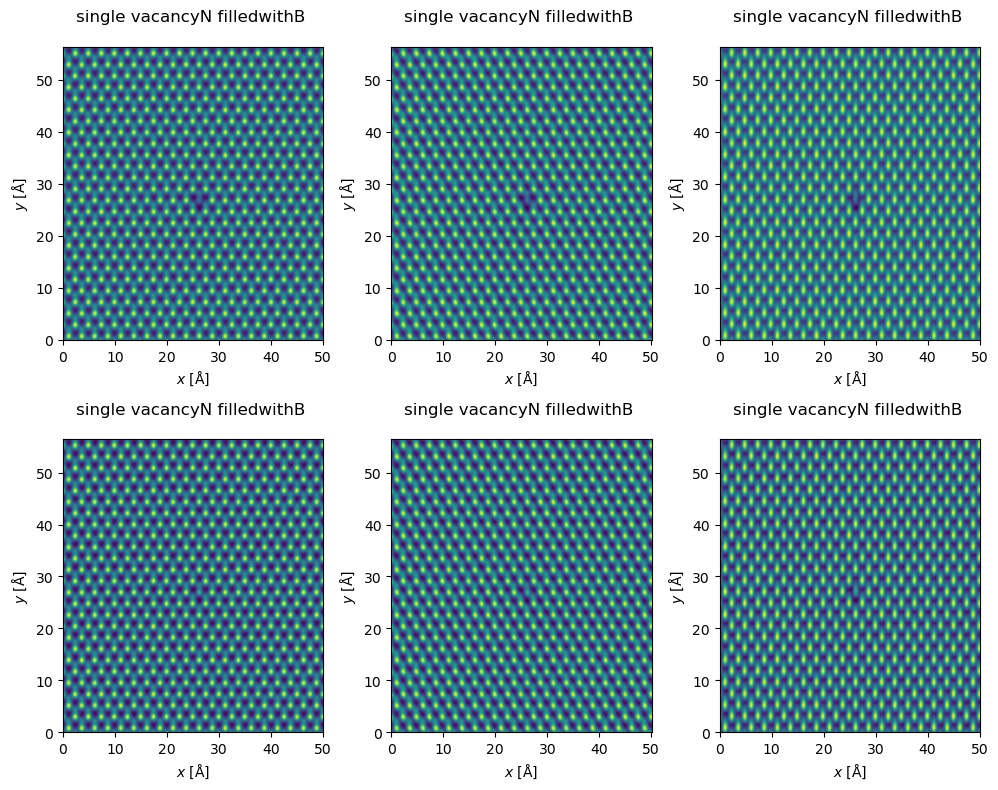

In [22]:
#plot
#CHOOSE:
columns = 3
zoom = 'no' #'yes' for zooming in

#FIX
rows = int(np.ceil(len(measurements_list)/columns))
fig, axs = plt.subplots(rows, columns, figsize=(10, rows*4))

i=0
for row in range(rows):
    for col in range(columns):
        try:
            final_measurements[i].show(ax=axs[row, col], explode=False, cbar=False, title=True) 
            
            #axs[row, col].set_title(parameter_info_sorted[0][i])
            axs[row, col].set_title(parameter_info[0])

            i += 1

            if zoom == 'yes':
                axs[row, col].set_ylim(23,33)
                axs[row, col].set_xlim(20,30)
        except IndexError:
            axs[row, col].set_visible(False)
        
plt.tight_layout()

#fig.figure.savefig('./data/raw_no_abberations_numconfig20/images/overview_postprocessed_no_abb1.png', bbox_inches='tight')

### NOISE

In [ ]:
#noise to account for finite electrone dose -> statistic deviation (see abtem walkthrough -> scan & detect)
#noisy_measurements = final_measurements.poisson_noise(dose_per_area=dose, seed=100)


In [ ]:
#noisy_measurements_plot = abtem.stack(noisy_measurements, parameter_info)
#noisy_measurements_plot[5:7].show(explode=True, figsize=(12, 4))
